In [1]:
import sys
sys.path.append('/global/homes/j/jpiat/')

import numpy as np
from astropy.io import fits
from astropy.table import vstack,Table
import matplotlib.pyplot as plt
from Relativistic_effects.split_mocks import split_magnitudes
from Relativistic_effects.split_mocks_eff import split_mag_eff

In [2]:
path_in = '/global/cfs/cdirs/desi/cosmosim/SecondGenMocks/AbacusSummit/CutSky/BGS/v0.1/z0.200/'
file_cutsky = path_in+'cutsky_BGS_z0.200_AbacusSummit_base_c000_ph006.fits'
#file_cutsky = '/global/cfs/cdirs/desi/users/sbrieden/abacus/Ab_c000_ph006/z0.200/BGS_SecondGen/cutsky_BGS_z0.200_AbacusSummit_base_c000_ph006_pot.fits'

m_lim = 19.5   # BGS magnitude cut
n_bins = 20    # number of redshift bins
z_max = 0.5    # max redshift

path_out = '/pscratch/sd/j/jpiat/Abacus/Ab_c000_ph006/z0.200/Split/BGS/'

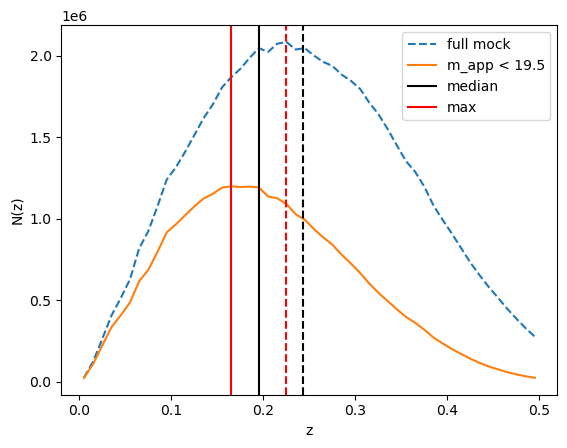

In [5]:
# redshfit distribution 

sky = fits.open(file_cutsky)
data = sky[1].data
sky.close()
    
z_cos = data['Z_COSMO']
m_app = data['R_MAG_APP']

cond = (np.isnan(m_app)==False)*(m_app<=m_lim)

z = z_cos[cond]

dz = 0.01
bins = np.arange(0,0.5+dz,dz)
z_bin = bins[:-1]+dz/2
h_cos, _ = np.histogram(z_cos,bins=bins)
h, _ = np.histogram(z,bins=bins)

z_cos_med = np.median(z_cos)
z_cos_max = z_bin[h_cos == np.max(h_cos)]

z_med = np.median(z)
z_max = z_bin[h == np.max(h)]


plt.plot(z_bin,h_cos,'--',label='full mock')
plt.plot(z_bin,h,label='m_app < 19.5')
plt.axvline(z_med,color='k',label='median')
plt.axvline(z_max,color='r',label='max')
plt.axvline(z_cos_med,color='k',ls='--')
plt.axvline(z_cos_max,color='r',ls='--')
plt.xlabel('z')
plt.ylabel('N(z)')
plt.legend()

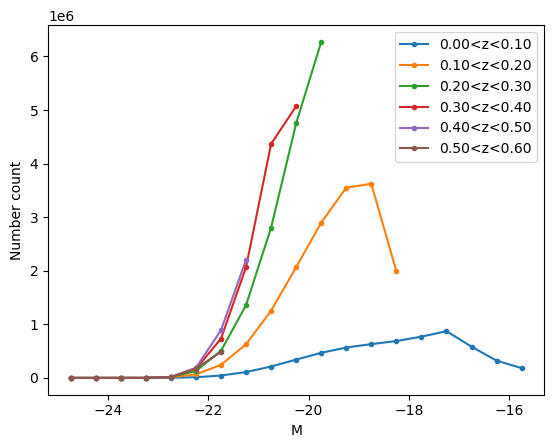

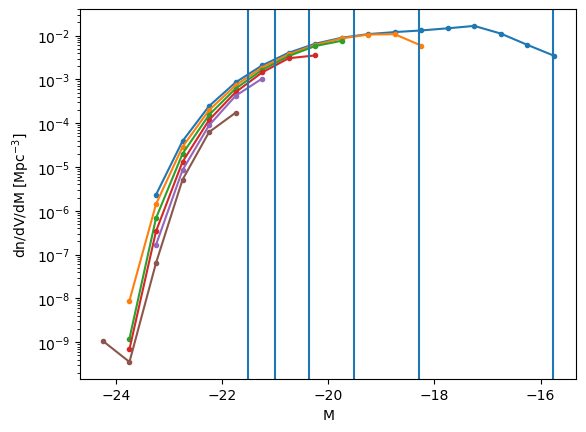

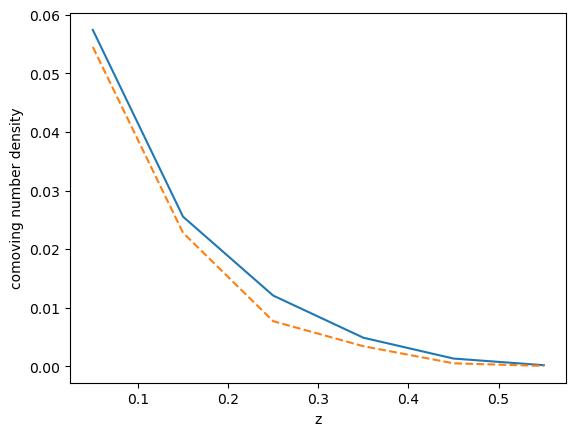

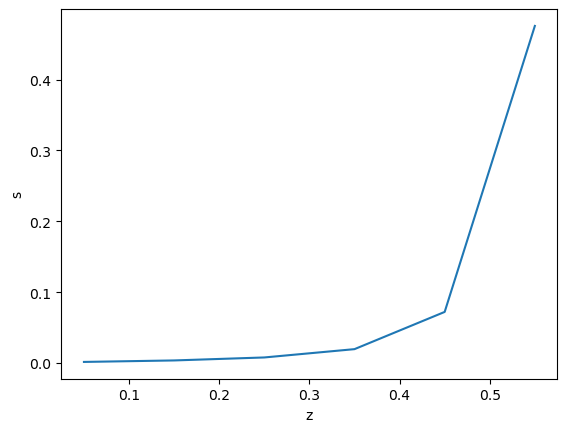

In [20]:
# comoving number density

import sys
sys.path.append('/global/homes/j/jpiat/shared_code/abacus_mocks/')
from hodpy.cosmology import CosmologyAbacus
from scipy.integrate import trapezoid as trap
from hodpy.k_correction import GAMA_KCorrection
from hodpy import lookup

cosmo = CosmologyAbacus(0)  #c000 cosmology
kcorr_r = GAMA_KCorrection(cosmo, k_corr_file=lookup.kcorr_file, cubic_interpolation=True)

sky = fits.open(file_cutsky)
data = sky[1].data
sky.close()
    
z = data['Z_COSMO']
M = data['R_MAG_ABS']

M = M + 0.8*(z-0.1)

znbins = 6

Mmin = -25
Mmax = -10
M_int = Mmax - Mmin

zbins = np.linspace(0., 0.6,znbins+1)
zc = 0.5*(zbins[1:]+zbins[:-1])

#n1 = np.zeros(znbins)
#n2 = np.zeros(znbins)
#s = np.zeros(znbins)

fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()

D_L = (1.+zc) * cosmo.comoving_distance(zc)
M_lim = 20.2 - 5*np.log10(D_L) - 25


for i in range(znbins):
    
    Mi = M[(z>=zbins[i])&(z<zbins[i+1])]
    
    Mbins = np.arange(-25., M_lim[i]+0.5, 0.5)
    dM = Mbins[1]-Mbins[0]
    Mc = 0.5*(Mbins[1:]+Mbins[:-1])
    
    d1 = cosmo.comoving_distance(zbins[i])
    d2 = cosmo.comoving_distance(zbins[i+1])
    vol = 4/3*np.pi*(d2**3-d1**3)
    
    n1[i] = len(Mi)/vol
    
    Nc = np.histogram(Mi,bins=Mbins)[0]
    LF = Nc/vol/dM
    
    n2[i] = trap(LF,Mc)
    
    valid = LF > 0
    
    s = (LF[valid][-1] - LF[valid][-2])/(Mc[valid][-1]-Mc[valid][-2])
    
    ax1.plot(Mc, Nc, marker = '.', label = '{0:.2f}<z<{1:.2f}'.format(zbins[i],zbins[i+1]))
    ax1.set_xlabel('M')
    ax1.set_ylabel('Number count')
    ax1.legend()
    
    ax2.plot(Mc[valid], LF[valid], marker = '.')
    ax2.set_xlabel('M')
    ax2.set_ylabel('dn/dV/dM [Mpc$^{-3}$]')
    ax2.set_yscale('log')
    ax2.axvline(M_lim[i])
    
plt.figure()
plt.xlabel('z')
plt.ylabel('comoving number density')
plt.plot(zc, n1)
plt.plot(zc, n2,'--')

s = 1/n1*1/np.log(10)*s

plt.figure()
plt.xlabel('z')
plt.ylabel('s')
plt.plot(zc, s)

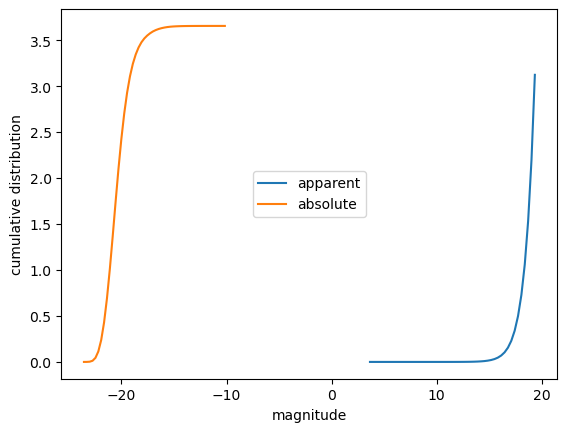

50 / 50 
effective magnification biases: s_bright = 0.6208346259290011, s_faint = 0.3319114607559108, ds = 0.28892316517309025
50 / 50 
effective magnification biases: s_bright = 0.006524846842931012, s_faint = 0.0061452422537236475


In [3]:
cut_bright = [10,20,30,40,50,60,70,80,90]
cut_faint = [90,80,70,60,50,40,30,20,10]
space = 'real'

cut_bright = [50]
cut_faint = [50]

#mag_bias = np.zeros((len(cut_bright),5))

for i, (cut_b, cut_f) in enumerate(zip(cut_bright, cut_faint)):
    
     s, sM = split_mag_eff(file_cutsky, space, m_lim, z_max, n_bins, cut_b, cut_f, path_out)    
    
    #mag_bias[i] = cut_b,cut_f,s_b,s_f,ds
    
#path = '/global/homes/j/jpiat/data/'
#np.savetxt(path+f"mag_bias_{space}.dat", mag_bias)

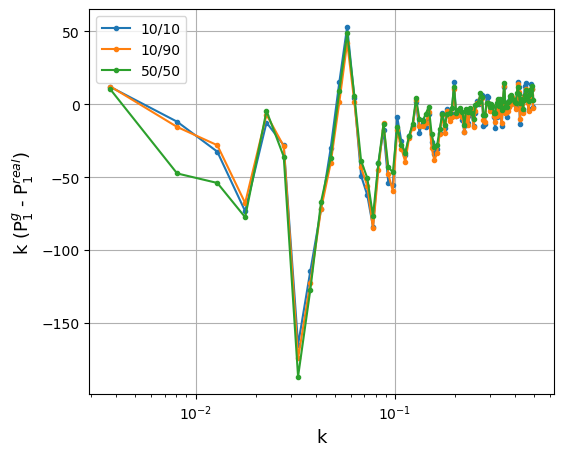

In [5]:
cuts_b = [10,10,50]
cuts_f = [10,90,50]

plt.figure(figsize=(6,5))
    
for cut_b, cut_f in zip(cuts_b, cuts_f):
    
    data = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_b{cut_b}_f{cut_f}.dat')
    data_real = np.loadtxt(f'/global/homes/j/jpiat/data/Pk1_real_b{cut_b}_f{cut_f}.dat')
    
    
    k = data[:,0]
    pk1 = data[:,1]
    pk1_real = data_real[:,1]
    
    plt.plot(k,k*(pk1-pk1_real),marker='.',label=f'{cut_b}/{cut_f}')
    plt.ylabel(r'k (P$^g_1$ - P$^{real}_1$)',fontsize=13)
    plt.xlabel('k', fontsize=13)
    plt.xscale('log')
    plt.grid()
    plt.legend();

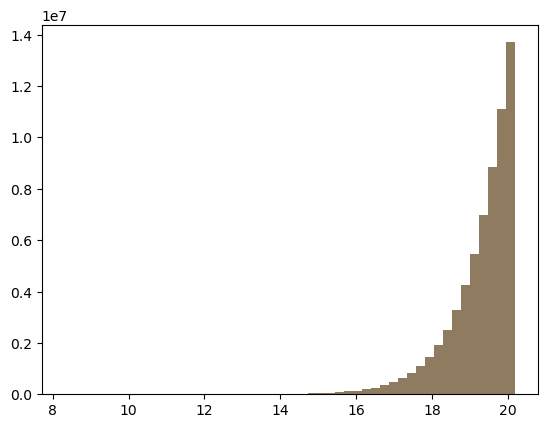

In [6]:
#file = '/global/cfs/cdirs/desi/users/sbrieden/abacus/Ab_c000_ph006/z0.200/BGS_SecondGen/cutsky_BGS_z0.200_AbacusSummit_base_c000_ph006_pot.fits'

file_b = '/pscratch/sd/j/jpiat/Abacus/Ab_c000_ph006/z0.200/Split/BGS/cutsky_real_zmax0.5_m19.5_bright_50.fits'
#file_r = '/pscratch/sd/j/jpiat/Abacus/Ab_c000_ph006/z0.200/Split/BGS/randoms_10_cutsky_zmax0.5.fits'
file_r = '/global/cfs/cdirs/desi/cosmosim/SecondGenMocks/AbacusSummit/CutSky/BGS/v0.1/z0.200/random_S100_1X.fits'
file_cutsky =  '/global/cfs/cdirs/desi/cosmosim/SecondGenMocks/AbacusSummit/CutSky/BGS/v0.1/z0.200/cutsky_BGS_z0.200_AbacusSummit_base_c000_ph000.fits'

cutsky = fits.open(file_cutsky)
#print(cutsky[1].columns)
data = cutsky[1].data
cutsky.close()

#sky_b = Table.read(file_b)
sky_r = Table.read(file_r)

plt.hist(data['R_MAG_APP'],50)
plt.hist(sky_r['R_MAG_APP'],50,alpha=0.5);

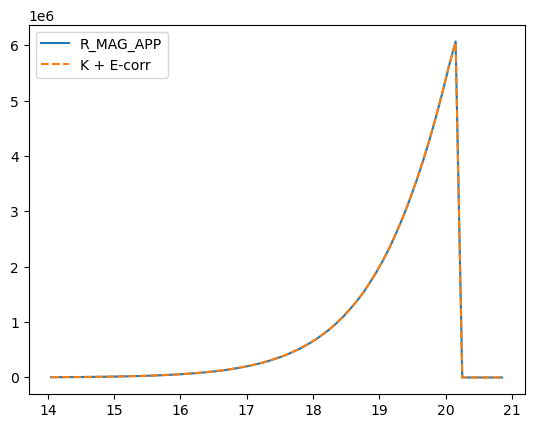

In [45]:
import sys
sys.path.append('/global/homes/j/jpiat/shared_code/abacus_mocks/')

from hodpy.cosmology import CosmologyAbacus
from hodpy.k_correction import GAMA_KCorrection
from hodpy import lookup
from Relativistic_effects.gravitational_redshift import z_grav

cosmo = CosmologyAbacus(0)  #c000 cosmology
kcorr_r = GAMA_KCorrection(cosmo, k_corr_file=lookup.kcorr_file, cubic_interpolation=True)

file_cutsky = '/global/cfs/cdirs/desi/users/sbrieden/abacus/Ab_c000_ph006/z0.200/BGS_SecondGen/cutsky_BGS_z0.200_AbacusSummit_base_c000_ph006_pot.fits'

#file_cutsky = '/global/cfs/cdirs/desi/cosmosim/SecondGenMocks/AbacusSummit/CutSky/BGS/v0.1/z0.200/random_S100_1X.fits'

#file_cutsky = '/global/cfs/cdirs/desi/cosmosim/SecondGenMocks/AbacusSummit/CutSky/BGS/v0.1/z0.200/cutsky_BGS_z0.200_AbacusSummit_base_c000_ph000.fits'

cutsky = fits.open(file_cutsky)
data = cutsky[1].data
cutsky.close()

z_cos = data['Z_COSMO']
z = data['Z']
#m_mock = data['R_MAG_APP']
M = data['R_MAG_ABS']
g_r = data['G_R_REST']
#phi = data['Pot A Soft 7']
#phi0 = phi[z==np.min(z)]

#z = z_grav(z_cos, z, phi, phi0)

Q = 0.8
EC =  Q*(z - 0.1)
m = kcorr_r.apparent_magnitude(M, z, g_r)-EC

m = m[m<=20.2]

#
#EC =  Q*(z - 0.1)
#m = kcorr_r.apparent_magnitude(M, z, g_r)-1*EC
#
#EC_g =  Q*(z_g - 0.1)
#m_g = kcorr_r.apparent_magnitude(M, z_g, g_r)-1*EC_g


mbins = np.arange(14,21,0.1)
mcenters = mbins[:-1]+0.05

hm, _ = np.histogram(m,bins=mbins)
#hm_mock, _ = np.histogram(m_mock,bins=mbins)

plt.figure()
plt.plot(mcenters, hm_mock, label='R_MAG_APP')
plt.plot(mcenters, hm, ls = '--', label='K + E-corr')
plt.legend();

In [5]:
file_sam = '/global/cfs/cdirs/desi/users/sbrieden/abacus/Ab_c000_ph006/z0.200/BGS_SecondGen/cutsky_BGS_z0.200_AbacusSummit_base_c000_ph006_pot.fits'
file_alex = '/global/cfs/cdirs/desi/cosmosim/SecondGenMocks/AbacusSummit/CutSky/BGS/v0.1/z0.200/cutsky_BGS_z0.200_AbacusSummit_base_c000_ph006.fits'

sky_sam = fits.open(file_sam)
sam = sky_sam[1].data
sky_sam.close()

sky_alex = fits.open(file_alex)
alex = sky_alex[1].data
sky_alex.close()

z_sam = sam['Z']
z_alex = alex['Z']

M = sam['R_MAG_ABS']
g_r = sam['G_R_REST']

Text(0, 0.5, 'N(z)')

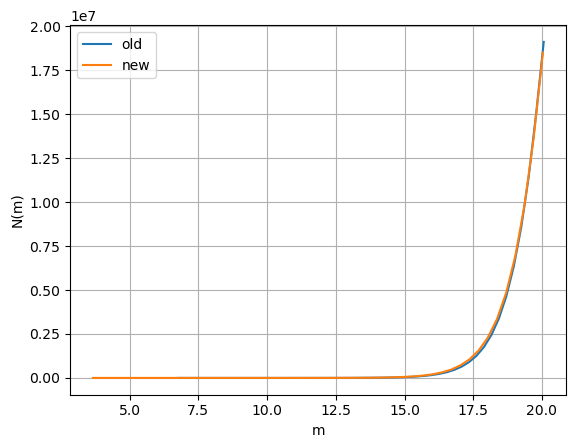

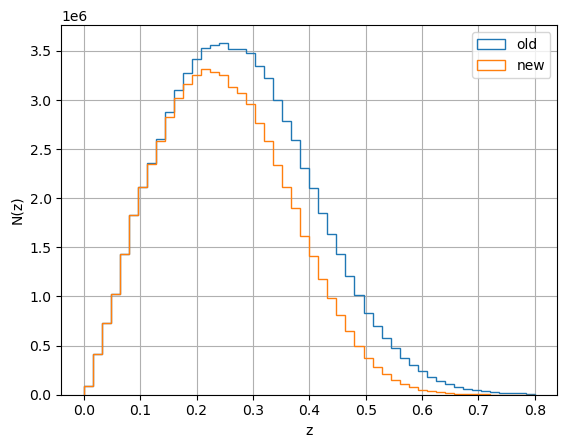

In [9]:
m_sam = sam['R_MAG_APP']
m_alex = alex['R_MAG_APP']

h_sam, bins_s = np.histogram(m_sam,50)
bins_s = (bins_s[1:]+bins_s[:-1])/2
h_alex, bins_a = np.histogram(m_alex,50)
bins_a = (bins_a[1:]+bins_a[:-1])/2

plt.figure()
plt.plot(bins_s, h_sam, label = 'old')
plt.plot(bins_a, h_alex, label = 'new')
plt.grid()
plt.xlabel('m')
plt.ylabel('N(m)')
plt.legend()

plt.figure()
plt.hist(z_sam, 50, label = 'old', histtype = 'step')
plt.hist(z_alex, 50, label = 'new', histtype = 'step')
plt.grid()
plt.legend()
plt.xlabel('z')
plt.ylabel('N(z)')

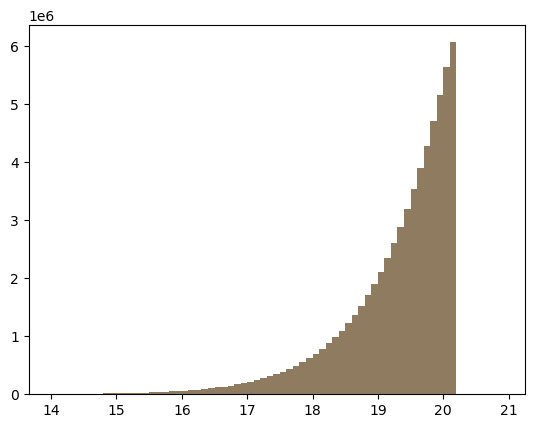

In [44]:
Q = 0.8
EC =  Q*(z - 0.1)
m = kcorr_r.apparent_magnitude(M, z_sam, g_r)-EC

m = m[m <= 20.2]

mbins = np.arange(14,21,0.1)

plt.hist(m,bins=mbins)
plt.hist(alex['R_MAG_APP'], bins=mbins,alpha=0.5);

In [15]:
import sys
sys.path.append('/global/homes/j/jpiat/shared_code/abacus_mocks/')

from hodpy.cosmology import CosmologyAbacus
from hodpy.k_correction import GAMA_KCorrection
from hodpy import lookup
from Relativistic_effects.gravitational_redshift import z_grav

cosmo = CosmologyAbacus(0)  #c000 cosmology
kcorr_r = GAMA_KCorrection(cosmo, k_corr_file=lookup.kcorr_file, cubic_interpolation=True)

file_cutsky = '/global/cfs/cdirs/desi/users/sbrieden/abacus/Ab_c000_ph006/z0.200/BGS_SecondGen/cutsky_BGS_z0.200_AbacusSummit_base_c000_ph006_pot.fits'
file_random = '/pscratch/sd/j/jpiat/Abacus/Ab_c000_ph006/z0.200/Split/BGS/randoms_10_cutsky_grav_zmax0.5.fits'

cutsky = fits.open(file_cutsky)
data = cutsky[1].data
cutsky.close()

randsky = fits.open(file_random)
rand = randsky[1].data
randsky.close()

M = data['R_MAG_ABS']
g = data['G_R_REST']

z_cos = data['Z_COSMO']
z = data['Z']
phi = data['Pot A Soft 7']
phi0 = phi[z_cos == np.min(z_cos)]
z_g = z_grav(z_cos,z,phi,phi0)

z_r = rand['Z']

In [16]:
#m_r = kcorr_r.apparent_magnitude(M_r, z_r, g_r) - 0.8*(z_r-0.1)
m_g = kcorr_r.apparent_magnitude(M, z_g, g) - 0.8*(z_g-0.1)

#cond = (z_r<=0.5) & (m_r<=19.5)
cond_g = (z<=0.5) & (m_g<=19.5)

#z_r = z_r[cond]
z_g = z_g[cond_g]

zmax = max(np.max(z_r), np.max(z_g))

zbins = np.arange(0,zmax,0.01)
zcenters = zbins[:-1]+0.005

hz, _ = np.histogram(z_r,bins=zbins,density=True)
hz_g, _ = np.histogram(z_g,bins=zbins,density=True)

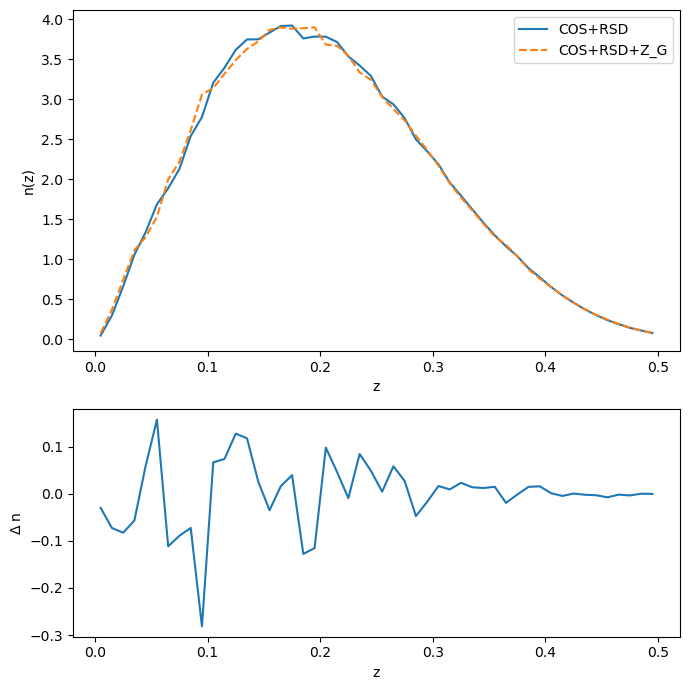

In [17]:
fig, axs = plt.subplots(2, 1, figsize = (7,7), layout='tight',height_ratios=[3, 2])

axs[0].plot(zcenters, hz,label='COS+RSD')
axs[0].plot(zcenters, hz_g, '--', label='COS+RSD+Z_G')
axs[0].set_ylabel('n(z)')
axs[0].set_xlabel('z')

axs[1].plot(zcenters, (hz-hz_g))
axs[1].set_ylabel(r'$\Delta$ n')
axs[1].set_xlabel('z')

axs[0].legend();

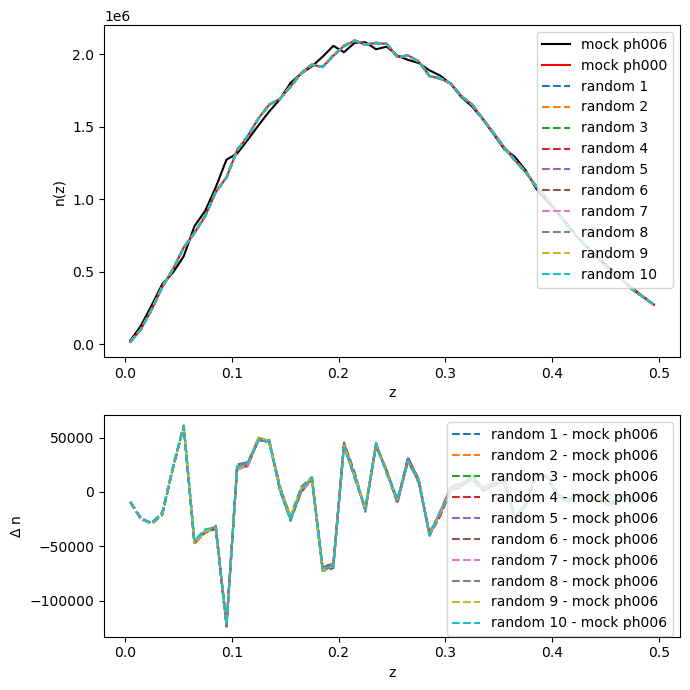

In [16]:
path_in = '/global/cfs/cdirs/desi/cosmosim/SecondGenMocks/AbacusSummit/CutSky/BGS/v0.1/z0.200/'

file_cutsky0 = '/global/cfs/cdirs/desi/cosmosim/SecondGenMocks/AbacusSummit/CutSky/BGS/v0.1/z0.200/cutsky_BGS_z0.200_AbacusSummit_base_c000_ph000.fits'
file_cutsky6 = '/global/cfs/cdirs/desi/cosmosim/SecondGenMocks/AbacusSummit/CutSky/BGS/v0.1/z0.200/cutsky_BGS_z0.200_AbacusSummit_base_c000_ph006.fits'

cutsky0 = fits.open(file_cutsky0)
data0 = cutsky0[1].data
cutsky0.close()

cutsky6 = fits.open(file_cutsky6)
data6 = cutsky6[1].data
cutsky6.close()

dz = 0.01
zbins = np.arange(0,0.5+dz,dz)
zb = zbins[:-1]+0.005


h0, _ = np.histogram(data0['Z'],bins=zbins)
h6, _ = np.histogram(data6['Z'],bins=zbins)


fig, axs = plt.subplots(2, 1, figsize = (7,7), layout='tight',height_ratios=[3, 2])

axs[0].plot(zb, h6, 'k', label='mock ph006')
axs[0].plot(zb, h0, 'r', label='mock ph000')
axs[0].set_ylabel('n(z)')
axs[0].set_xlabel('z')

n_randoms = 10

for i in range(1,n_randoms+1):
        
    input_file = path_in+'random_S'+str(i)+'00_1X.fits'
    
    sky = fits.open(input_file)
    data = Table(sky[1].data)
    sky.close()
    
    h, _ = np.histogram(data['Z'],bins=zbins)
    
    axs[0].plot(zb, h, '--', label=f'random {i}')
    
    axs[1].plot(zb, (h-h6), '--', label = f'random {i} - mock ph006')
    axs[1].set_ylabel(r'$\Delta$ n')
    axs[1].set_xlabel('z')
    
        
axs[0].legend(loc='upper right')
axs[1].legend();

In [9]:
import sys
sys.path.append('/global/homes/j/jpiat/shared_code/abacus_mocks/')

import numpy as np
from hodpy.cosmology import CosmologyAbacus
from hodpy.k_correction import GAMA_KCorrection
from hodpy import lookup

cosmo = CosmologyAbacus(0)  #c000 cosmology
kcorr_r = GAMA_KCorrection(cosmo, k_corr_file=lookup.kcorr_file, cubic_interpolation=True)


#z = np.ones(len(M)) * 0.4

#gr = np.ones(len(z)) * 0.5
#print(kcorr_r.k(z, gr))
#print(cosmo.comoving_distance(z))

z = np.arange(0.1,0.6,0.1)
M = np.linspace(-22,-17,len(z))
gr = np.ones(len(z)) * 0.5

D = np.array([292.58372014, 570.41929934, 833.30733785, 1081.39386244, 1315.09205009])

print(kcorr_r.apparent_magnitude(M, z, gr))
print(M + 5*np.log10((1.+z)*D) + 25 + kcorr_r.k(z,gr))
print(cosmo.comoving_distance(z)-D)

check
[15.43473636 18.35122602 20.62299216 22.66757258 24.62872663]
[15.4347325  18.35122405 20.62299081 22.66757154 24.62872577]
[0.00051957 0.00051883 0.00051848 0.00051835 0.00051848]


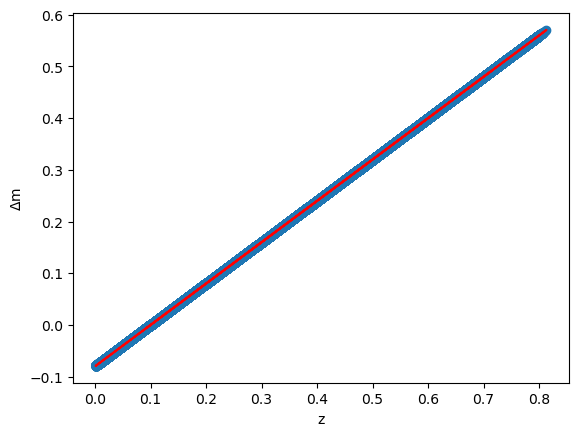

In [15]:
plt.figure()
plt.scatter(z_cos,m-m_mock)
plt.xlabel('z')
plt.ylabel(r'$\rm \Delta$m')
plt.plot(z_cos,EC,'r')

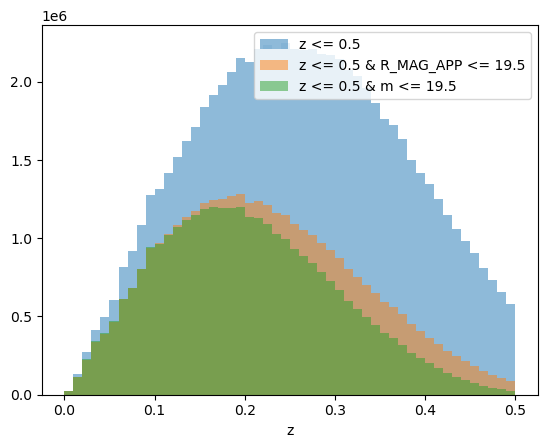

In [3]:
cond1 = (z<=0.5) & (m_mock<=19.5) 
cond2 = (z<=0.5) & (m<=19.5)
cond3 = (z<=0.5)
z1 = z[cond1]
z2 = z[cond2]
z3 = z[cond3]

plt.figure()
plt.hist(z3, 50, alpha = 0.5, label = 'z <= 0.5')
plt.hist(z1, 50, alpha = 0.5, label = 'z <= 0.5 & R_MAG_APP <= 19.5')
plt.hist(z2, 50, alpha = 0.5, label = 'z <= 0.5 & m <= 19.5')
plt.xlabel('z')
plt.legend();

In [10]:
(-15)**(1/3)

(1.2331060371652351+2.135802307490103j)